<a href="https://colab.research.google.com/github/WuzI38/AiSD/blob/main/MidiGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attempt on music generation

## Get the data

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wuzi91","key":"ed735dab09a4f84e30d1d94d4c843b42"}'}

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download programgeek01/anime-music-midi

100% 707k/707k [00:00<00:00, 901kB/s]
100% 707k/707k [00:00<00:00, 900kB/s]


In [6]:
# Unzip data
import zipfile

zip_ref = zipfile.ZipFile("anime-music-midi.zip", "r") # Hey, don't blame me for the name, I am not this dataset's creator
zip_ref.extractall()
zip_ref.close()

### Fix music21 show issues

In [7]:
# enables music21 to render images of musical notes
print('installing lilypond...')
!apt-get install lilypond > /dev/null

installing lilypond...
Extracting templates from packages: 100%


In [8]:
# enables playing midi files
print('installing fluidsynth...')
!apt-get install fluidsynth > /dev/null

installing fluidsynth...


In [9]:
# Copy soundfont to content directory
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

## Loading and preprocessing

### Parsing files from given path

In [10]:
import os
from music21 import *

path = "/content/data/undertale/"
midi_list = []
for filename in os.listdir(path):
  # print(filename)
  parsed_file = converter.parse(path + filename)
  midi_list.append(parsed_file)

In [11]:
midi_list[1] # Midi 1 is battle against true hero

<music21.stream.Score 0x7f6a69804a30>

### Extracting notes from music21 stream

In [12]:
# (This cell is mostly stolen from kaggle, but does it really matter?)
# I turned it into a dict cuz I have no idea how to use the library

def part_to_dict(midi_part):
  # If what I think is correct midi stream is divided into midi parts which 
  # Represents instruments (or left/right hand piano melody)
  notes_as_dict = []
  for n in midi_part.flat.notes:     
    sound_dict = dict()
    if isinstance(n, note.Note):
      sound_dict["type"] = "Note"
      sound_dict["pitch"] = max(0.0, n.pitch.ps)
      sound_dict["duration"] = n.duration.quarterLength
    elif isinstance(n, chord.Chord):
      sound_dict["type"] = "Chord"
      sound_dict["pitches"] = [] 
      for pitch in n.pitches:
        sound_dict["pitches"].append(max(0.0, pitch.ps))
    sound_dict["duration"] = n.duration.quarterLength
    sound_dict["offset"] = n.offset
    notes_as_dict.append(sound_dict)
    
  return notes_as_dict

part_to_dict(midi_list[1])[0:5]

[{'type': 'Note', 'pitch': 57.0, 'duration': 0.25, 'offset': 0.0},
 {'type': 'Chord', 'pitches': [60.0, 64.0], 'duration': 0.25, 'offset': 0.5},
 {'type': 'Note', 'pitch': 52.0, 'duration': 0.25, 'offset': 1.0},
 {'type': 'Chord', 'pitches': [60.0, 64.0], 'duration': 0.25, 'offset': 1.25},
 {'type': 'Note', 'pitch': 57.0, 'duration': 0.25, 'offset': 1.75}]

In [13]:
# Original function (no dict)
def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
      if isinstance(nt, note.Note):
        ret.append(max(0.0, nt.pitch.ps))
        parent_element.append(nt)
      elif isinstance(nt, chord.Chord):
        for pitch in nt.pitches:
          ret.append(max(0.0, pitch.ps))
          parent_element.append(nt)
    
    return ret, parent_element
extract_notes(midi_list[1])[1][0:5]

[<music21.note.Note A>,
 <music21.chord.Chord C4 E4>,
 <music21.chord.Chord C4 E4>,
 <music21.note.Note E>,
 <music21.chord.Chord C4 E4>]

### Divide midi into midi parts

In [14]:
def fragmentise(midi_stream):
  return [part.flat.notes for part in midi_stream.parts]

parts = fragmentise(midi_list[1])
part_to_dict(parts[0])[0:5]

[{'type': 'Note', 'pitch': 57.0, 'duration': 0.25, 'offset': 0.0},
 {'type': 'Chord', 'pitches': [60.0, 64.0], 'duration': 0.25, 'offset': 0.5},
 {'type': 'Note', 'pitch': 52.0, 'duration': 0.25, 'offset': 1.0},
 {'type': 'Chord', 'pitches': [60.0, 64.0], 'duration': 0.25, 'offset': 1.25},
 {'type': 'Note', 'pitch': 57.0, 'duration': 0.25, 'offset': 1.75}]

## Turn those midi files into somethig readable... I mean visualization

### Creating play and show functions

In [15]:
import music21
from IPython.display import Image, Audio

def show(music):
  display(Image(str(music.write('lily.png'))))

def play(music):
  filename = music.write('mid')
  !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
  display(Audio(filename + '.wav'))

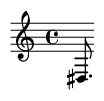

In [16]:
n = music21.note.Note('D#3')
n.duration = duration.Duration(0.75)
show(n)

In [17]:
play(n)

### Visualizing the first 12 sounds using extracted notes only 
I know, I don't have to create midi stream once again, but I just wanna check if it works as intended

In [18]:
def create_midi_part(part_n):
  sounds_12 = []
  # Create really ugly and unnecessary for loop just for 
  for sound in part_n:
    if sound["type"] == "Note":
      new_note = note.Note(sound["pitch"], quarterLength=sound["duration"]) # use .nameWithOctave for note name only
    else:
      new_note = chord.Chord([int (s) for s in sound["pitches"]], quarterLength=sound["duration"])
    new_note.offset = sound["offset"]
    sounds_12.append(new_note)
  return sounds_12 

  # This is so bad... but the melody is correct, so I shouldn't complain

In [19]:
part_1 = part_to_dict(parts[0])[:48]
# part_2 = part_to_dict(parts[1])[:10]
midi_part_1 = create_midi_part(part_1)
# midi_part_2 = create_midi_part(part_2)

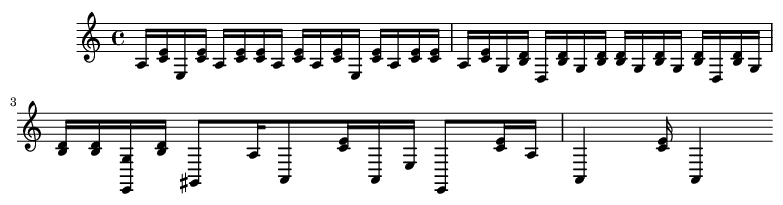

In [20]:
# Visualize stream
melody_midi = stream.Stream(midi_part_1)
# melody_midi_2 = stream.Stream(midi_part_2)
# melody_joined = stream.Stream([melody_midi, melody_midi_2])
melody_joined = melody_midi
show(melody_joined) # Yep, looks legit

In [21]:
# melody_midi.show('text') There are even two instruments playing together... nice
play(melody_joined)

## Stats

### Counting notes
Soooo... I assume there are some notes that appear more frequently than the others. I guess I should do something similar to what text models try to accomplish and remove useless sounds (use just top 95%)?

As the initial research on how to use the library was made, this time I will create a function(based on part_to_dict function) that represents notes as values dependent of time (timesteps) - (offset, pitch, length).

In [45]:
def get_all_notes(midi_piece, notes_only=False):
  all_notes = []
  midi_part = fragmentise(midi_piece)[0] # use only notes that belong to main melody
  for nt in midi_part.flat.notes: 
    if isinstance(nt, note.Note):
      all_notes.append((nt.offset, max(0.0, nt.pitch.ps), nt.duration.quarterLength) if not notes_only else nt.pitch.ps)
    elif isinstance(nt, chord.Chord):
      for n in nt.pitches:
        all_notes.append((nt.offset, max(0.0, n.ps), nt.duration.quarterLength) if not notes_only else n.ps)
  return all_notes

notes_list = get_all_notes(midi_list[0])
notes_list[:10]

[(0.0, 83.0, 2.0),
 (1.75, 88.0, 2.0),
 (2.0, 95.0, 2.0),
 (4.0, 83.0, 4.0),
 (4.0, 90.0, 4.0),
 (8.0, 88.0, 2.0),
 (10.0, 95.0, 2.0),
 (11.75, 73.0, 4.25),
 (12.0, 76.0, 4.0),
 (12.0, 83.0, 4.0)]

Count notes first

In [51]:
# Make a wrapper to use map later
def gan_true_wrapper(midi_piece):
  return get_all_notes(midi_piece, True)

all_midis_combined = (list(map))
